# Forecasting Bitcoin

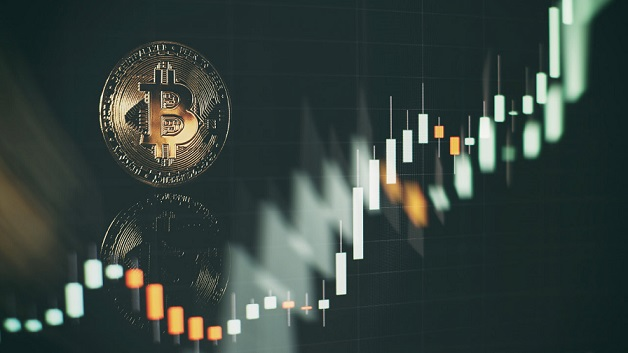

In [37]:
from IPython import display
display.Image(os.path.normpath("../Artwork/bitcoin small.jpg"))

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import os

In [2]:
# Daily Data for BTC-USD< March 21, 2021 - March 21, 2022
# https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch
df = pd.read_csv(os.path.normpath('../Data/BTC-USD.csv'))
df.shape
df_orig = df.copy()

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-21,58309.914063,58767.898438,56005.617188,57523.421875,57523.421875,51943414539
1,2021-03-22,57517.890625,58471.480469,54288.156250,54529.144531,54529.144531,56521454974
2,2021-03-23,54511.660156,55985.441406,53470.695313,54738.945313,54738.945313,56435023914
3,2021-03-24,54710.488281,57262.382813,52514.332031,52774.265625,52774.265625,70567223787
4,2021-03-25,52726.746094,53392.386719,50856.570313,51704.160156,51704.160156,67999812841


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2022-03-17,41140.843750,41287.535156,40662.871094,40951.378906,40951.378906,22009601093
362,2022-03-18,40944.839844,42195.746094,40302.398438,41801.156250,41801.156250,34421564942
363,2022-03-19,41794.648438,42316.554688,41602.667969,42190.652344,42190.652344,19664853187
364,2022-03-20,42191.406250,42241.164063,41004.757813,41247.824219,41247.824219,20127946682
365,2022-03-21,41259.656250,41452.421875,40691.011719,41143.101563,41143.101563,23399933952


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,366.000000,366.000000,366.000000,366.000000,366.000000,3.660000e+02
mean,46817.756569,47991.220997,45429.304650,46759.900658,46759.900658,3.790523e+10
std,9255.895324,9345.445957,9176.155275,9230.284474,9230.284474,1.592969e+10
min,29796.285156,31006.187500,28893.621094,29807.347656,29807.347656,1.373656e+10
25%,39111.136719,40091.232422,37812.997070,39113.262696,39113.262696,2.690064e+10
50%,46250.050781,47287.888672,44536.906250,46146.767578,46146.767578,3.431238e+10
75%,55015.682618,56843.900391,53558.691406,54932.342773,54932.342773,4.319186e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,1.263581e+11


In [6]:
# We will use the closing prices to make predictions.
df_close = df[['Date','Close']]

df_close = df_close.set_index('Date')
print ('Before sorting')
print (df_close.head(3))

# Sort the data in ascending chronological order.
df_close.sort_index(inplace=True)

print ('After sorting')
print (df_close.head(3))

Before sorting
                   Close
Date                    
2021-03-21  57523.421875
2021-03-22  54529.144531
2021-03-23  54738.945313
After sorting
                   Close
Date                    
2021-03-21  57523.421875
2021-03-22  54529.144531
2021-03-23  54738.945313


In [7]:
import warnings
warnings.filterwarnings('ignore')

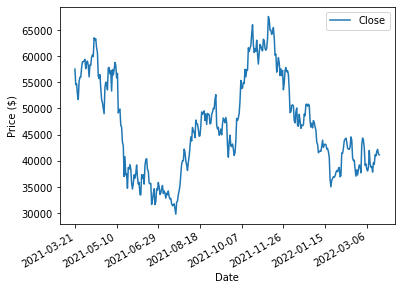

In [8]:
import matplotlib.dates as mdates
# Plot our data.
#fig=plt.figure(figsize=(20,16), dpi= 200, facecolor='w', edgecolor='k')

ax = df_close.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

# Rotate and right-align the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

In [9]:
# Data should be standardized before forecasting.
# Use Sklearn's minmax scaler to scale the data to [0,+1].
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_close['scale'] = scaler.fit_transform(df_close['Close'].values.reshape(-1,1))
df_close['scale'].head()

Date
2021-03-21    0.734016
2021-03-22    0.654718
2021-03-23    0.660274
2021-03-24    0.608242
2021-03-25    0.579902
Name: scale, dtype: float64

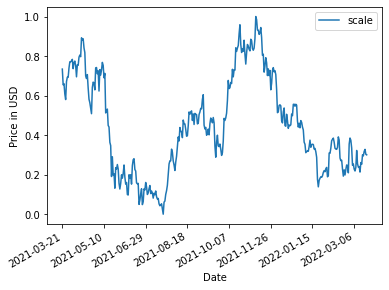

In [10]:
# Let's take a look at the scaled data.
ax = df_close.plot(y='scale')
ax.set_xlabel('Date')
ax.set_ylabel('Price in USD')

# Rotate and right-align the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

In [11]:
df = df[["Date", "Close"]]
df.columns = ["ds", "y"]
print(df)

             ds             y
0    2021-03-21  57523.421875
1    2021-03-22  54529.144531
2    2021-03-23  54738.945313
3    2021-03-24  52774.265625
4    2021-03-25  51704.160156
..          ...           ...
361  2022-03-17  40951.378906
362  2022-03-18  41801.156250
363  2022-03-19  42190.652344
364  2022-03-20  41247.824219
365  2022-03-21  41143.101563

[366 rows x 2 columns]


In [12]:
# Create historical data
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
x, y = create_dataset(df_close['scale'])
print(x.shape)
print(y.shape)

(362, 3)
(362,)


Text(0.5, 1.0, 'Forcasting Target')

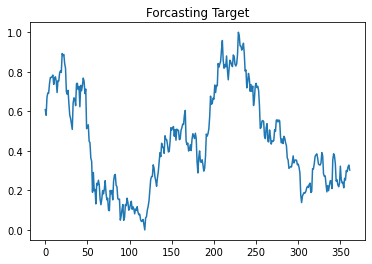

In [13]:
plt.plot(y)
plt.title('Forcasting Target')

# Split the Data

x_train (253, 3) [[0.7340163  0.65471761 0.66027385]
 [0.65471761 0.66027385 0.60824243]
 [0.66027385 0.60824243 0.57990238]
 [0.60824243 0.57990238 0.67082398]
 [0.57990238 0.67082398 0.69296939]] [0.60824243 0.57990238 0.67082398 0.69296939 0.69236648]
x_test (109, 3) [[0.74151494 0.720298   0.72624094]
 [0.720298   0.72624094 0.7063251 ]
 [0.72624094 0.7063251  0.63006424]
 [0.7063251  0.63006424 0.51360229]
 [0.63006424 0.51360229 0.51805533]] [0.7063251  0.63006424 0.51360229 0.51805533 0.5502003 ]


Text(0.5, 1.0, 'training forecasting target')

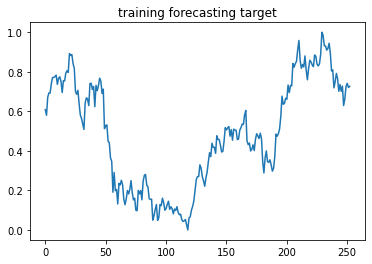

In [14]:
size = int(len(x) * 0.70)

x_train, x_test = x[0:size], x[size:len(x)]
y_train, y_test = y[0:size], y[size:len(x)]

print ('x_train', x_train.shape, x_train[:5], y_train[:5])
print ('x_test', x_test.shape, x_test[:5], y_test[:5])

plt.plot(y_train)
plt.title('training forecasting target')

# Multilayer Perceptron (MLP)

In [15]:
# Create a forecasting model
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(activation = 'tanh', solver='adam')

MSE training 0.0032164195878837095
MSE testing 0.0025101330172761713


Text(0.5, 1.0, 'Training Result')

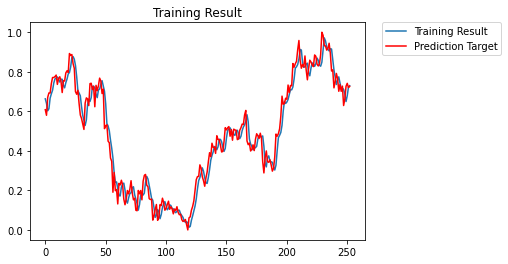

In [16]:
clf.fit(x_train, y_train)

train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)

print ('MSE training', mean_squared_error(train_pred, y_train))
print ('MSE testing', mean_squared_error(test_pred, y_test))

plt.plot(train_pred, label='Training Result')
plt.plot(y_train, color='red', label='Prediction Target')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training Result')

Text(0.5, 1.0, 'Testing Result')

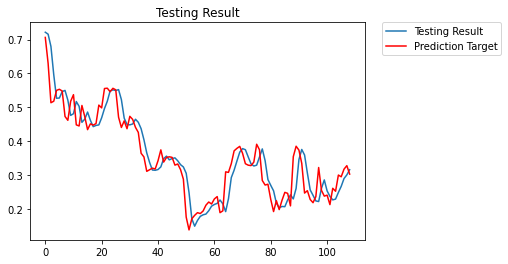

In [17]:
plt.plot(test_pred, label='Testing Result')
plt.plot(y_test, color='red',label='Prediction Target')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Testing Result')

Text(0.5, 1.0, 'Training result with Bitcoin prices.')

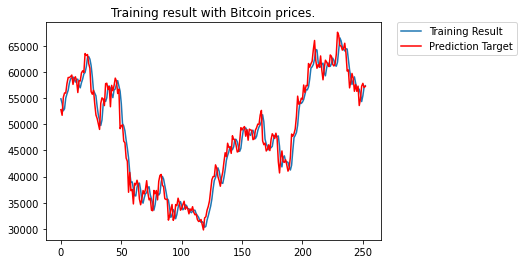

In [18]:
plt.plot(scaler.inverse_transform(train_pred.reshape(-1,1)),label='Training Result')
plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)),color='red', label='Prediction Target')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training result with Bitcoin prices.')

Text(0.5, 1.0, 'Error')

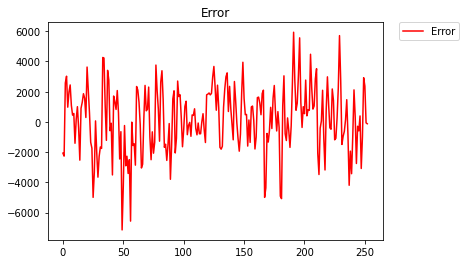

In [19]:
# Plot the error.
diff = scaler.inverse_transform(y_train.reshape(-1,1)) - scaler.inverse_transform(train_pred.reshape(-1,1)) 
plt.plot(diff, color='red', label='Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Error')

In [20]:
print(np.sum(diff))
print(np.mean(diff))

40479.767760346345
159.99908205670494


# SGDRegressor

In [21]:
# Try a couple of other regressors.
from sklearn.linear_model import SGDRegressor
clf2 = SGDRegressor(max_iter=1000000)
clf2.fit(x_train,y_train)

train_mse2 = clf2.predict(x_train)
test_mse2 = clf2.predict(x_test)
print ('MSE training', mean_squared_error(train_mse2, y_train))
print ('MSE testing', mean_squared_error(test_mse2, y_test))

MSE training 0.010120361361648312
MSE testing 0.007338086691258392


# SVR

In [22]:
from sklearn import svm
clf3 = svm.SVR()
clf3.fit(x_train,y_train)

train_mse3 = clf3.predict(x_train)
test_mse3 = clf3.predict(x_test)
print ('MSE training', mean_squared_error(train_mse3, y_train))
print ('MSE testing', mean_squared_error(test_mse3, y_test))

MSE training 0.0025893587521613848
MSE testing 0.0018338483502568469


# StackingRegressor with MLP, SGD, and SVR, and a final estimator using Random Forest

In [23]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
estimators = [
    ('MLP', MLPRegressor(activation = 'tanh', solver='adam')),
    ('SGD', SGDRegressor(max_iter=1000000)),
    ('SVR', svm.SVR())
]
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(n_estimators=10,
                                            random_state=42)
)

In [24]:
print("MLP: ")
clf.fit(x_train, y_train).score(x_test, y_test)

MLP: 


0.8330341746199706

In [25]:
print("SGD: ")
clf2.fit(x_train, y_train).score(x_test, y_test)

SGD: 


0.48376295628301436

In [26]:
print("SVR: ")
clf3.fit(x_train, y_train).score(x_test, y_test)

SVR: 


0.8725180776315705

In [27]:
print("Ensemble: ")
reg.fit(x_train, y_train).score(x_test, y_test)

Ensemble: 


0.7909941446262522

In [28]:
# The ensemble is doing worse than the best regressor!

# Can we do better?
# Remove SGD
estimators = [
    ('MLP', MLPRegressor(activation = 'tanh', solver='adam')),
    ('SVR', svm.SVR())
]
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

print("Ensemble: ")
reg.fit(x_train, y_train).score(x_test, y_test)

Ensemble: 


0.6816492500381253

# Do we need more base estimators?

In [29]:
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(n_estimators=1000,
                                          random_state=42)
)

print("Ensemble: ")
reg.fit(x_train, y_train).score(x_test, y_test)

Ensemble: 


0.7956242591147196

In [30]:
# Setting n_estimators to 10000 won't help.
estimators = clf3 #SVR
reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(n_estimators=100,
                                            random_state=42)
)

# Tune SVR
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import classification_report
# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]
tuned_parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}

scores = ["precision", "recall", "accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for {}".format(score))
    print()

    #clf = GridSearchCV(svm.SVR(), tuned_parameters, scoring="%s_macro" % score)
    clf = GridSearchCV(svm.SVR(), tuned_parameters)
    print("Ensemble: ")
    
    clf.fit(x_train, y_train).score(x_test, y_test)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    #print(classification_report(y_true, y_pred))
    print()
    

# Tuning hyper-parameters for precision

Ensemble: 
Best parameters set found on development set:

{'C': 10, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}

Grid scores on development set:

0.619 (+/-0.398) for {'C': 1.5, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}
-12.222 (+/-18.603) for {'C': 1.5, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'rbf'}
-12.223 (+/-18.604) for {'C': 1.5, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'poly'}
0.619 (+/-0.398) for {'C': 1.5, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
-11.290 (+/-17.498) for {'C': 1.5, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
-12.223 (+/-18.604) for {'C': 1.5, 'epsilon': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
-0.065 (+/-1.813) for {'C': 1.5, 'epsilon': 0.2, 'gamma': 1e-07, 'kernel': 'linear'}
-10.991 (+/-17.815) for {'C': 1.5, 'epsilon': 0.2, 'gamma': 1e-07, 'kernel': 'rbf'}
-10.992 (+/-17.816) for {'C': 1.5, 'epsilon': 0.2, 'gamma': 1e-07, 'kernel': 'poly'}
-0.065 (+/-1.813) for {'C': 1.5, 'epsilon'

In [31]:
# Best params
# Precision
# {'C': 10, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}

# Recall
# {'C': 10, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}

# Accuracy
# {'C': 10, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}

# Optimized SVR

In [32]:
svrO = svm.SVR(C=10, epsilon=0.1, gamma=1e-07, kernel='linear')
svrO.fit(x_train,y_train)

train_mse = svrO.predict(x_train)
test_mse = svrO.predict(x_test)
print ('MSE training', mean_squared_error(train_mse, y_train))
print ('MSE testing', mean_squared_error(test_mse, y_test))

print("Optimized SVR: ")
svrO.fit(x_train, y_train).score(x_test, y_test)

MSE training 0.0025622134011048727
MSE testing 0.001927699297871338
Optimized SVR: 


0.8659939289928249

In [33]:
# https://github.com/jieyima/Cryptocurrency_Investment_Analysis_and_Modeling/blob/master/Analysis_of_Cryptocurrency_Investments.ipynb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def regression(X_train, X_test, y_train, y_test):
    Regressor = {
        'Random Forest Regressor': RandomForestRegressor(n_estimators=200),
        'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=500),
        'ExtraTrees Regressor': ExtraTreesRegressor(n_estimators=500, min_samples_split=5),
        'Bayesian Ridge': BayesianRidge(),
        'Elastic Net CV': ElasticNetCV()
    }

    for name, clf in Regressor.items():
        print(name)
        print("Accuracy: {:.2f}".format(clf.fit(X_train, y_train).score(X_test, y_test)))
    
        print(f'R2: {r2_score(y_test, clf.predict(X_test)):.2f}')
        print(f'MAE: {mean_absolute_error(y_test, clf.predict(X_test)):.4f}')
        print(f'MSE: {mean_squared_error(y_test, clf.predict(X_test)):.4f}')
        print()

In [34]:
regression(x_train, x_test, y_train, y_test)

Random Forest Regressor
Accuracy: 0.82
R2: 0.82
MAE: 0.0387
MSE: 0.0026

Gradient Boosting Regressor
Accuracy: 0.79
R2: 0.79
MAE: 0.0428
MSE: 0.0030

ExtraTrees Regressor
Accuracy: 0.84
R2: 0.84
MAE: 0.0346
MSE: 0.0023

Bayesian Ridge
Accuracy: 0.88
R2: 0.88
MAE: 0.0287
MSE: 0.0017

Elastic Net CV
Accuracy: 0.88
R2: 0.88
MAE: 0.0288
MSE: 0.0017



In [35]:
# Try more regressors, and also boosting, bagging, and stacking to improve the accuracy.
# For each regressor review the hyperparameters and try to determine the best values
# or use an optimization technique.